In [65]:
import pandas as pd
import numpy as np
import os
import re
import datetime
import matplotlib.pyplot as plt

plt.style.use('seaborn')

from application.utils.ingestion import fetch_data, fetch_ts,convert_to_ts

In [2]:
data_dir = os.path.join("data","cs-train")
df = fetch_data(data_dir)

In [3]:
df.head()

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
0,United Kingdom,13085.0,28,489434,11,6.95,85048,12,2017,2017-11-28
1,United Kingdom,13085.0,28,489434,11,6.75,79323W,12,2017,2017-11-28
2,United Kingdom,13085.0,28,489434,11,2.10,22041,21,2017,2017-11-28
3,United Kingdom,13085.0,28,489434,11,1.25,21232,5,2017,2017-11-28
4,United Kingdom,13085.0,28,489434,11,1.65,22064,17,2017,2017-11-28


In [4]:
df.tail()

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
815006,United Kingdom,16098.0,31,562271,7,3.75,22725,2,2019,2019-07-31
815007,United Kingdom,16098.0,31,562271,7,3.75,22726,12,2019,2019-07-31
815008,United Kingdom,16098.0,31,562271,7,3.75,22727,6,2019,2019-07-31
815009,United Kingdom,14056.0,31,562269,7,2.95,22090,2,2019,2019-07-31
815010,United Kingdom,15628.0,31,562163,7,1.65,22558,12,2019,2019-07-31


## Missing values

In [23]:
## missing values summary
print("Missing Value Summary\n{}".format("-"*35))
print(df.isnull().sum(axis = 0))

Missing Value Summary
-----------------------------------
country              0
customer_id     189762
day                  0
invoice              0
month                0
price                0
stream_id            0
times_viewed         0
year                 0
invoice_date         0
dtype: int64


In [24]:
df.customer_id.isnull().sum()/df.shape[0]

0.2328336672756564

In [26]:
df[df.customer_id.isnull()].country.unique()

array(['United Kingdom', 'Nigeria', 'EIRE', 'Bahrain',
       'United Arab Emirates', 'Bermuda', 'Sweden', 'France', 'Hong Kong',
       'Lebanon', 'RSA', 'Unspecified', 'Portugal', 'Israel',
       'Switzerland'], dtype=object)

## Revenue

In [28]:
df_revenue_country = df[['country', 'price']].groupby('country').sum()
df_revenue_country.columns = ['revenue']
df_revenue_country.sort_values(by='revenue', inplace=True, ascending=False)

In [32]:
df_revenue_country['revenue'].values[0] / df_revenue_country['revenue'].values[1]

32.89006713512097

<BarContainer object of 43 artists>

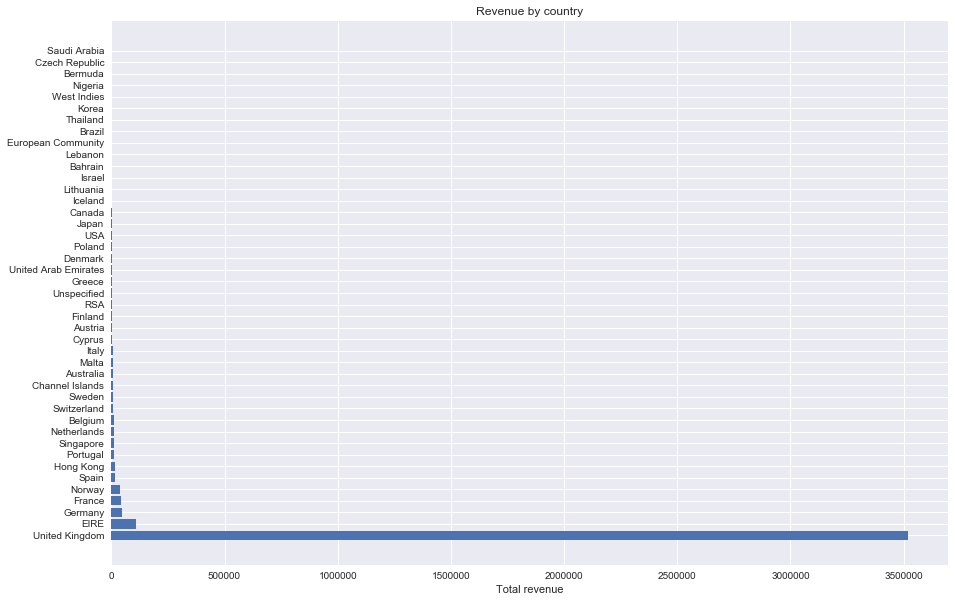

In [7]:
plt.figure(figsize=(15,10))
plt.title("Revenue by country")
plt.xlabel("Total revenue")
plt.barh(df_revenue_country.index, df_revenue_country.revenue)

<BarContainer object of 43 artists>

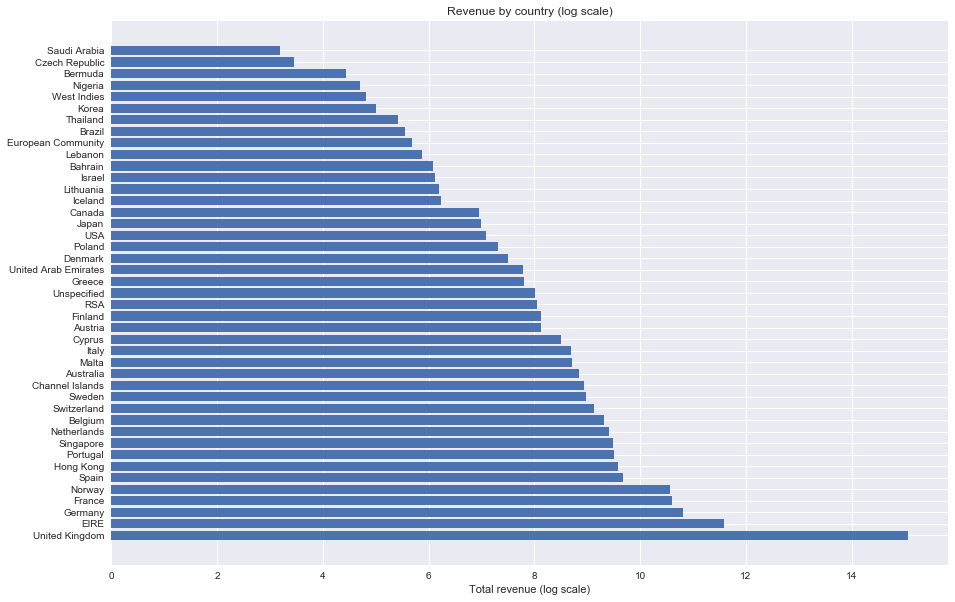

In [34]:
plt.figure(figsize=(15,10))
plt.title("Revenue by country (log scale)")
plt.xlabel("Total revenue (log scale)")
plt.barh(df_revenue_country.index, np.log(df_revenue_country.revenue))

## Dates

In [9]:
df.invoice_date.nunique()

495

In [10]:
df.invoice_date.min(), df.invoice_date.max()

(Timestamp('2017-11-28 00:00:00'), Timestamp('2019-07-31 00:00:00'))

In [33]:
(df.invoice_date.max() -  df.invoice_date.min()).days + 1

611

In [54]:
curr = df.invoice_date.min()
end = df.invoice_date.max()
date_list = []

while (curr<=end):
    date_list.append(curr)
    curr += datetime.timedelta(1)
    
dates_without_invoices = sorted(list(set(date_list).difference(set(df.invoice_date))))
len(dates_without_invoices)

116

In [55]:
df_revenue_date = df[['invoice_date', 'price']].groupby('invoice_date').sum()
df_revenue_date.columns = ['revenue']
df_revenue_date.sort_values(by='invoice_date', inplace=True, ascending=True)

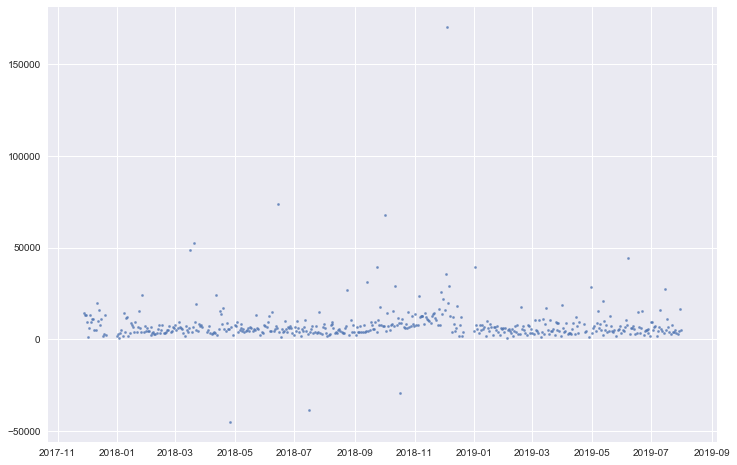

In [62]:
plt.figure(figsize=(12,8))
plt.scatter(df_revenue_date.index,df_revenue_date.revenue,s=5,alpha=0.8)

In [68]:
df_revenue_date[df_revenue_date.revenue<0]

,revenue
invoice_date,
2018-04-26,-44990.049
2018-07-16,-38702.940
2018-10-17,-29374.970


In [73]:
df[(df.invoice_date=="2018-04-26")&(df.price<0)]

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
180418,United Kingdom,NaN,26,506401,4,-53594.36,B,1,2018,2018-04-26


# Time series (converted)

In [66]:
df_ts = convert_to_ts(df)

In [67]:
df_ts

,date,purchases,unique_invoices,unique_streams,total_views,year_month,revenue
0,2017-11-01,0,0,0,0,2017-11,0.00
1,2017-11-02,0,0,0,0,2017-11,0.00
2,2017-11-03,0,0,0,0,2017-11,0.00
3,2017-11-04,0,0,0,0,2017-11,0.00
4,2017-11-05,0,0,0,0,2017-11,0.00
...,...,...,...,...,...,...,...
602,2019-06-26,1358,67,999,6420,2019-06,4903.17
603,2019-06-27,1620,80,944,9435,2019-06,5499.38
604,2019-06-28,1027,70,607,5539,2019-06,3570.60
605,2019-06-29,0,0,0,0,2019-06,0.00


In [74]:
df_ts[df_ts.revenue<0]

,date,purchases,unique_invoices,unique_streams,total_views,year_month,revenue
176,2018-04-26,2058,106,1046,11371,2018-04,-44990.049
257,2018-07-16,1448,68,786,8907,2018-07,-38702.940
350,2018-10-17,2491,122,1092,13319,2018-10,-29374.970
